In [ ]:
import requests
import pandas as pd
import yfinance as yf
pd.set_option('display.max_rows', None)


url = "https://en.wikipedia.org/wiki/List_of_S%26P_600_companies" 


def read_html_from_website(url):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        
        # Check if request was successful
        if response.status_code == 200:
            # Extract HTML content from the response
            html_content = response.text
            return html_content
        else:
            print("Failed to retrieve HTML. Status code:", response.status_code)
            return None
    except Exception as e:
        print("An error occurred:", e)
        return None

# # # Create 

html_content = read_html_from_website(url)
list_df = pd.read_html(html_content)
df = list_df[0]
df = df.drop(columns=["SEC filings","CIK"])
df = df.dropna()
#df = df.head(20)
df


In [ ]:
import pandas as pd
import yfinance as yf

# Assuming you have an existing DataFrame named df with a column 'Symbol' containing tickers

# Iterate through each row using iterrows()
for index, row in df.iterrows():
    ticker = row['Symbol']  # Extract ticker from the current row

    # Get financial data using yfinance
    ticker_obj = yf.Ticker(ticker)

    try:
        # Get desired financial information
        total_assets = ticker_obj.balance_sheet.T['Total Assets'].iloc[0]
        total_debt = ticker_obj.balance_sheet.T['Total Debt'].iloc[0]
        total_revenue = ticker_obj.income_stmt.T['Total Revenue'].iloc[0]
        net_income = ticker_obj.income_stmt.T['Net Income'].iloc[0]
        current_liabilities = ticker_obj.balance_sheet.T['Current Liabilities'].iloc[0]
        current_assets = ticker_obj.balance_sheet.T['Current Assets'].iloc[0]
        inventory = ticker_obj.balance_sheet.T['Inventory'].iloc[0]

        # Check for incomplete data
        if any(pd.isnull(value) for value in [total_assets, total_debt, total_revenue, net_income, current_liabilities, current_assets, inventory]):
            print(f"{ticker} removed from df: Incomplete data")
            df = df[df['Symbol'] != ticker]  # Remove ticker from DataFrame
            continue  # Skip to the next iteration if data is incomplete

        # Calculate derived metrics
        debt_ratio = total_debt / total_assets
        calculated_profit_margin = net_income / total_revenue
        asset_turnover_ratio = total_revenue / total_assets
        liquidity_ratio = current_assets / current_liabilities
        quick_ratio = (current_assets - inventory) / current_liabilities

        # Add calculated metrics to DataFrame
        df.loc[index, 'Total Assets'] = total_assets
        df.loc[index, 'Total Debt'] = total_debt
        df.loc[index, 'Debt Ratio'] = debt_ratio
        df.loc[index, 'Total Revenue'] = total_revenue
        df.loc[index, 'Net Income'] = net_income
        df.loc[index, 'Inventory'] = inventory
        df.loc[index, 'Calculated Profit Margin'] = calculated_profit_margin
        df.loc[index, 'Asset Turnover Ratio'] = asset_turnover_ratio
        df.loc[index, 'Current Liabilities'] = current_liabilities
        df.loc[index, 'Current Assets'] = current_assets
        df.loc[index, 'Liquidity Ratio'] = liquidity_ratio
        df.loc[index, 'Quick Ratio'] = quick_ratio

    except KeyError:
        print(f"Error: Missing data for ticker {ticker}")
        
        df = df[df['Symbol'] != ticker] 

# Print or save the updated DataFrame
df

# df.to_csv("updated_financial_data.csv", index=False)  
# Example to save as CSV


In [ ]:
import yfinance as yf
ticker_object = yf.Ticker('AAON')
balancesheet = ticker_object.balance_sheet
print(balancesheet)

In [ ]:
pd.set_option('display.max_rows', None)

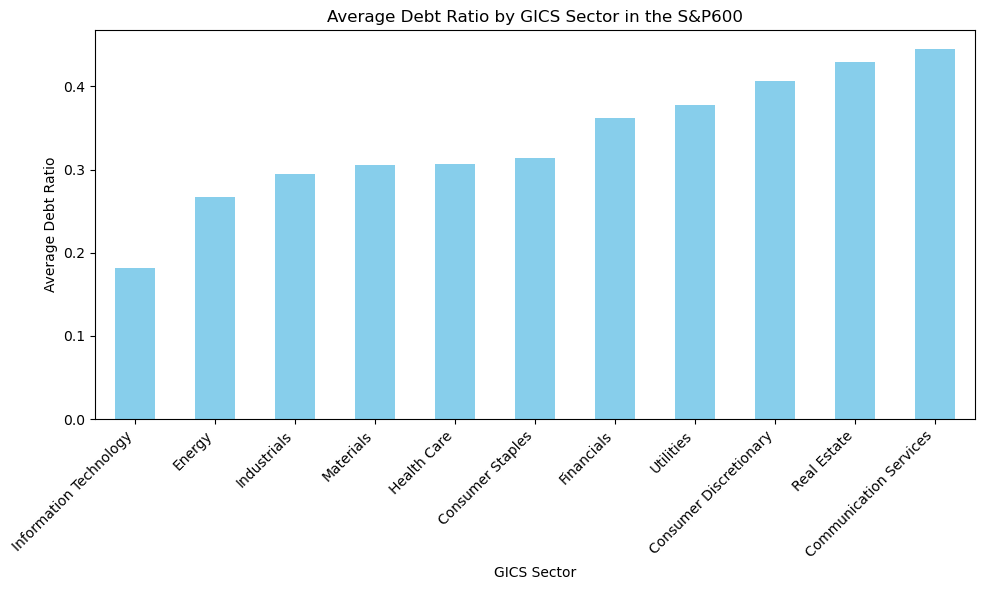

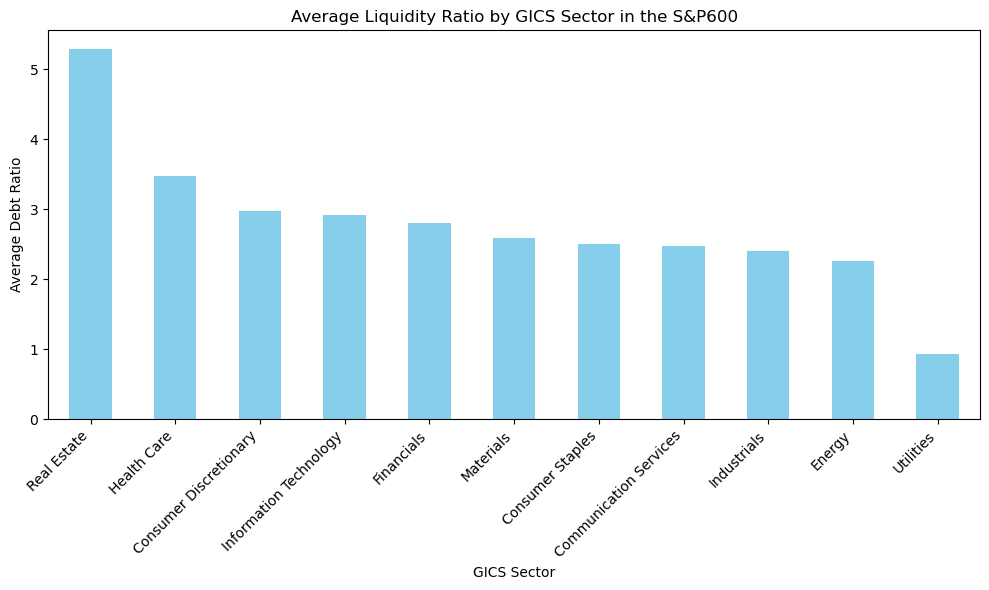

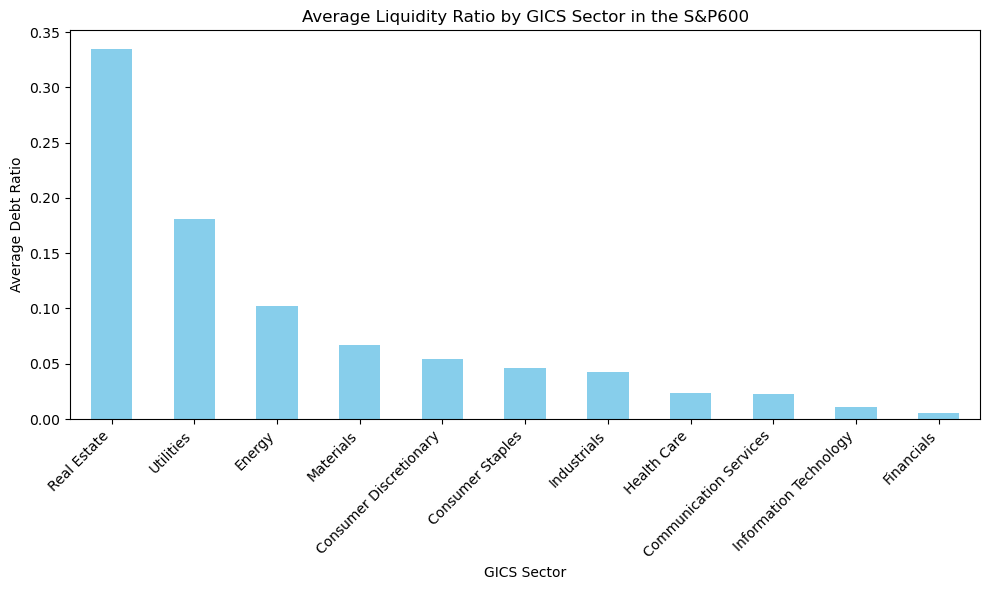

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df with columns "GICS Sector" and "Debt Ratio"

# Grouping the DataFrame by "GICS Sector" and calculating the average of "Debt Ratio"

sector_avg_debt_ratio = df.groupby('GICS Sector')["Debt Ratio"].mean()
sector_avg_debt_ratio = sector_avg_debt_ratio.sort_values(ascending=True)


# Plot Debt ratio graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sector_avg_debt_ratio.plot(kind='bar', color='skyblue')
plt.title("Average Debt Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Debt Ratio")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('plot.png')
#plt.show()

# Plot liquidity ratio graph

sector_avg_liquidity = df.groupby('GICS Sector')["Liquidity Ratio"].mean()
sector_avg_liquidity = sector_avg_liquidity.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sector_avg_liquidity.plot(kind='bar', color='skyblue')
plt.title("Average Liquidity Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Debt Ratio")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('plot1.png')

# Plot liquidity ratio graph

sector_avg_profit = df.groupby('GICS Sector')["Calculated Profit Margin"].mean()
sector_avg_profit = sector_avg_profit.sort_values(ascending=True)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sector_avg_profit.plot(kind='bar', color='skyblue')
plt.title("Average profit margin by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Debt Ratio")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('plot2.png')

